# RECOM maps for offshore wind North Sea


Authors:
- Harald G Svendsen
- Til Kristian Vrana

In [1]:
import geopandas
import pyproj
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shapely
import colorcet as cc # to get extra perceptually uniform colormaps

# File created by the script ninja_download_northsea_offshorewind.py:
file_timeseries = "timeseries_5y.csv"

# File containing offshore wind capacity scenario:
# (This one is based on work in the Norwegian Ocean Grid project)
file_wind_scenario = "windfarms_scenario.csv"

In [2]:
# Download shapefiles and replace
world = geopandas.read_file("/Users/hsven/OneDrive - SINTEF/DATA/GIS/shapefiles/ne_50m_land.zip")
borders = geopandas.read_file("/Users/hsven/OneDrive - SINTEF/DATA/GIS/shapefiles/ne_50m_admin_0_boundary_lines_land.zip")
borders_sea = geopandas.read_file("/Users/hsven/OneDrive - SINTEF/DATA/GIS/shapefiles/World_maritime_Boundaries.zip")

lambert_equal_area = "+proj=laea +lat_0=58 +lon_0=6 +x_0=4321000 +y_0=3210000 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"

def plot_recov_map(Z,cmap="viridis",title=None,filename=None,levels=None,ticks=None,contour_lines=None,zorder=1,
        world_border_only=False,dpi=150,pdf=False,scale=1,ax=None,colorbar=True,colobar_shrink=1):
    # EPSG:9820 Lambert equal area
    #proj = "EPSG:9820"
    proj = lambert_equal_area #"EPSG:4326" #"EPSG:3395"
    p1=pyproj.Proj(lambert_equal_area,preserve_units=False)
    X,Y = np.meshgrid(Z.columns, Z.index)
    xcoords,ycoords=p1(X,Y)
    if ax is None:
        plt.figure(figsize=(5*scale,6*scale))
        ax=plt.gca()
    if world_border_only:
        world.to_crs(proj).boundary.plot(ax=ax,color="lightgray",zorder=2)
    else:
        world.to_crs(proj).plot(ax=ax,color="lightgray",zorder=2)
    borders.to_crs(proj).plot(ax=ax,color="gray",zorder=2)
    borders_sea.to_crs(proj).plot(ax=ax,color="gray",zorder=1.1)
    #minmax = p1([-3,16.5],[51,66])
    minmax = p1([-2,16.5],[51,65]) # cap in the north
    ax.set_xlim(minmax[0][0],minmax[0][1])
    ax.set_ylim(minmax[1][0],minmax[1][1])

    if levels is None:
        levels = 20
    vmin = None
    vmax = None
    if (type(levels) is list):
        vmin = min(levels)
        vmax = max(levels)
    cf = ax.contourf(xcoords, ycoords, Z,levels=levels, vmin=vmin, vmax=vmax, zorder=zorder,cmap=cmap,extend="both")
    if colorbar:
        plt.colorbar(cf,ticks=ticks,aspect=20*scale,extendfrac=0.05/scale,shrink=colobar_shrink)
    if contour_lines is not None:
        ax.contour(xcoords,ycoords,Z,levels=contour_lines,colors="black",zorder=1.2,linestyles="dotted")
    ax.set_xticks([])
    ax.set_yticks([])
    if pdf:
        filename = filename+".pdf"
    if filename is not None:
        plt.savefig(filename,bbox_inches='tight',dpi=dpi)    
    return cf

In [3]:

df_all_wind = pd.read_csv(file_timeseries,index_col=0,header=[0,1,2])

df_all_wind.columns = df_all_wind.columns.set_levels(df_all_wind.columns.levels[0].astype(float), level=0)
df_all_wind.columns = df_all_wind.columns.set_levels(df_all_wind.columns.levels[1].astype(float), level=1)
df_all_wind=df_all_wind.sort_index(axis=1)
lat_range_infile=df_all_wind.columns.get_level_values(0).unique()
lon_range_infile=df_all_wind.columns.get_level_values(1).unique()
lat_range = lat_range_infile
lon_range = lon_range_infile

delta_lat = lat_range[1]-lat_range[0]
delta_lon = lon_range[1]-lon_range[0]

coords=[]
#world_red = world.buffer(-0.3)
for lat in lat_range: 
    for lon in lon_range:
        #if (not world_red.contains(shapely.geometry.Point(lon,lat)).any()) and ( lat < (71-64)/10*lon+64):
        coords.append((lon,lat))
print(f"Number of points = {len(coords)}")

num_pts = df_all_wind.xs("electricity",level=2,axis=1).shape[1]
datapoints = pd.DataFrame(index=range(num_pts),columns=["geometry"])
databoxes = pd.DataFrame(index=range(num_pts),columns=["geometry"])

i=0
for col in df_all_wind.xs("electricity",level=2,axis=1).columns:
    lat = col[0]
    lon = col[1]
    if True:
        datapoints.at[i,"lat"] = lat
        datapoints.at[i,"lon"] = lon
        databoxes.at[i,"lat"] = lat
        databoxes.at[i,"lon"] = lon        
        datapoints.at[i,"geometry"] = shapely.geometry.Point(lon,lat)
        databoxes.at[i,"geometry"] = shapely.geometry.Polygon([
            [lon-delta_lon/2,lat-delta_lat/2],
            [lon+delta_lon/2,lat-delta_lat/2],
            [lon+delta_lon/2,lat+delta_lat/2],
            [lon-delta_lon/2,lat+delta_lat/2]])
        i=i+1
datapoints = geopandas.GeoDataFrame(datapoints,crs="EPSG:4326")
databoxes = geopandas.GeoDataFrame(databoxes,crs="EPSG:4326")
datapoints = datapoints.set_index(["lat","lon"])
databoxes = databoxes.set_index(["lat","lon"])

Number of points = 256


[]

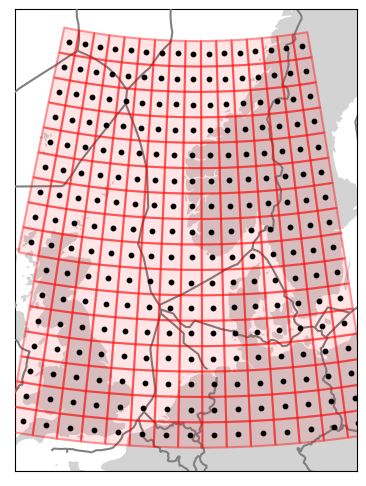

In [4]:
#lambert_equal_area = "+proj=laea +lat_0=58 +lon_0=6 +x_0=4321000 +y_0=3210000 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"
proj = lambert_equal_area #"EPSG:4326" #"EPSG:3395"

p1=pyproj.Proj(proj,preserve_units=True)
plt.figure(figsize=(5,6))
ax=plt.gca()
world.to_crs(proj).plot(ax=ax,color="lightgray")
borders.to_crs(proj).plot(ax=ax,color="gray")
borders_sea.to_crs(proj).plot(ax=ax,color="gray",zorder=10)
databoxes.to_crs(proj).plot(ax=ax,facecolor="red",alpha=0.1,zorder=10) # box fill
databoxes.to_crs(proj).boundary.plot(ax=ax,edgecolor="red",alpha=0.4,zorder=10) # box edges
datapoints.to_crs(proj).plot(ax=ax,color="black",markersize=10,zorder=10)
minmax = p1([-5,22],[49,67])
ax.set_xlim(minmax[0][0],minmax[0][1])
ax.set_ylim(minmax[1][0],minmax[1][1])
ax.set_xticks([])
ax.set_yticks([])
#plt.savefig("output/fig_data_area.png",bbox_inches='tight',dpi=150)  

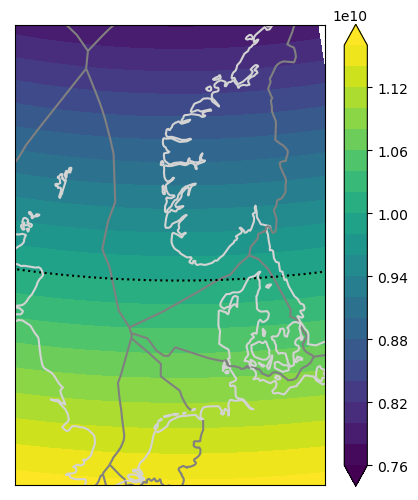

In [5]:
# Area per data box
proj = lambert_equal_area
plot_recov_map(
    Z=(databoxes.to_crs(proj).area).sort_index().unstack(),
    zorder=0,world_border_only=True,
    contour_lines=[1e10],
    title=f"Area scaling factor")

2025: Wind capacity SUM = 39.54 GW
2030: Wind capacity SUM = 93.87 GW
2035: Wind capacity SUM = 154.43 GW
2040: Wind capacity SUM = 205.87 GW


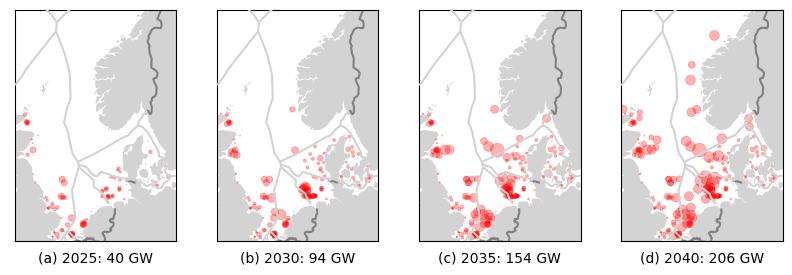

In [6]:
# ALL in subplots

plt.figure(figsize=(10,3))
#fig,axs = plt.subplots(nrows=1,ncols=4,figsize=(10,3))
labels = ["a","b","c","d"]
i=1
for wind_year in ["2025", "2030", "2035", "2040"]:
    # Read scenario for expected wind power capacity in given year ("2040")
    windfarms2040 = pd.read_csv(file_wind_scenario)
    windfarms2040 = windfarms2040[["lat","lon",wind_year]]
    windfarms2040 = windfarms2040[windfarms2040[wind_year]>0]

    # Wind capacity per box:
    wind_cols = df_all_wind.xs("electricity",axis=1,level=2).columns
    wind_cap = pd.Series(index=wind_cols, data=0.0)
    for lat,lon in wind_cols:
        mask_lat = (
            (windfarms2040["lat"]-lat).between(-delta_lat/2,delta_lat/2,inclusive="right")
        )
        mask_lon = (
            (windfarms2040["lon"]-lon).between(-delta_lon/2,delta_lon/2,inclusive="right")
        )
        cap_incl = windfarms2040.loc[mask_lat & mask_lon,wind_year].sum()
        wind_cap[(lat,lon)] = cap_incl/1000
    print(f"{wind_year}: Wind capacity SUM = {wind_cap.sum():.2f} GW")


    # Expected capacity
    proj = lambert_equal_area
    ax = plt.subplot(1,4,i)
    #ax = axs[i-1]
    world.to_crs(proj).plot(ax=ax,color="lightgray")
    borders.to_crs(proj).plot(ax=ax,color="gray")
    borders_sea.to_crs(proj).plot(ax=ax,color="lightgray",zorder=10)
    wf_x,wf_y = p1(windfarms2040["lon"],windfarms2040["lat"])
    ax.scatter(x=wf_x,y=wf_y,s=windfarms2040[wind_year]*1/60,alpha=0.3,color="red",linewidth=0.5)
    #minmax = p1([-5,22],[49,67])
    minmax = p1([-3,16.5],[51,66])
    minmax = p1([-2.5,16.5],[51,65]) # cap in the north
    ax.set_xlim(minmax[0][0],minmax[0][1])
    ax.set_ylim(minmax[1][0],minmax[1][1])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(f"({labels[i-1]}) {wind_year}: {wind_cap.sum():2.0f} GW")
    i = i+1

#plt.savefig(f"output/fig_expected_capacity_scatter_ALL.png",dpi=300,bbox_inches='tight')


Wind capacity SUM = 39.54299 GW (2025)
equivalent capacity 0
Equivalent capacity 2025 (40 GW)
Wind capacity SUM = 93.87433470146637 GW (2030)
equivalent capacity 1
Equivalent capacity 2030 (94 GW)
Wind capacity SUM = 154.42549922553957 GW (2035)
equivalent capacity 2
Equivalent capacity 2035 (154 GW)
Wind capacity SUM = 205.87433470146635 GW (2040)
equivalent capacity 3
Equivalent capacity 2040 (206 GW)


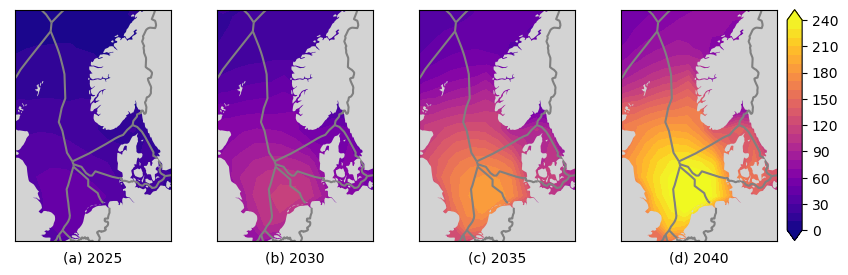

In [109]:
# ALL in subplots

#plt.figure(figsize=(10,3.5))
fig,axs = plt.subplots(nrows=1,ncols=4,figsize=(10,3))
labels = ["a","b","c","d"]
i=0
#ax=None
for wind_year in ["2025", "2030", "2035", "2040"]:
    # Read scenario for expected wind power capacity in given year ("2040")
    windfarms2040 = pd.read_csv("C:/Users/hsven/code/grid_optimisation/windfarm_data/saved_data/windfarms.csv")
    windfarms2040 = windfarms2040[["lat","lon",wind_year]]
    windfarms2040 = windfarms2040[windfarms2040[wind_year]>0]

    # Wind capacity per box:
    wind_cols = df_all_wind.xs("electricity",axis=1,level=2).columns
    wind_cap = pd.Series(index=wind_cols, data=0.0)
    for lat,lon in wind_cols:
        mask_lat = (
            (windfarms2040["lat"]-lat).between(-delta_lat/2,delta_lat/2,inclusive="right")
        )
        mask_lon = (
            (windfarms2040["lon"]-lon).between(-delta_lon/2,delta_lon/2,inclusive="right")
        )
        cap_incl = windfarms2040.loc[mask_lat & mask_lon,wind_year].sum()
        wind_cap[(lat,lon)] = cap_incl/1000
    print(f"Wind capacity SUM = {wind_cap.sum()} GW ({wind_year})")


    # Computations:

    # Wind values at (lat=64,lon=-3.5) are too low, so replace by mean of neighbours instead:
    correct_64_35 = True
    if correct_64_35:
        df_all_wind[(64,-3.5,"wind_speed")] = df_all_wind[[
            (64,-5,"wind_speed"),
            (64,-2,"wind_speed"),
            (63,-3.5,"wind_speed"),
            (65,-3.5,"wind_speed")]].mean(axis=1)
        df_all_wind[(64,-3.5,"electricity")] = df_all_wind[[
            (64,-5,"electricity"),
            (64,-2,"electricity"),
            (63,-3.5,"electricity"),
            (65,-3.5,"electricity")]].mean(axis=1)

    # Mean and standard deviations:
    df_all_windspeed = df_all_wind.xs("wind_speed",axis=1,level=2).copy()
    df_all_wind2 = df_all_wind.xs("electricity",axis=1,level=2).copy()
    wind_sum = df_all_wind.xs("electricity",axis=1,level=2).dot(wind_cap)
    wind_sum_std = wind_sum.std()
    wind_std = df_all_wind2.std()
    wind_mean = df_all_wind2.mean()
    cap_factors = wind_mean
    mean_cap_factors = wind_sum.mean()/wind_cap.sum()  # 0.53 = typical value

    # Covariance:
    df_all_wind2[(0,0)] = wind_sum
    wind_cov_all =df_all_wind2.cov()
    variance_sum = wind_cov_all.loc[(0,0),(0,0)] # = std_sum^2
    wind_cov = wind_cov_all[(0,0)].drop((0,0))#/wind_mean
    wind_cov_factor = wind_cov/(variance_sum/wind_cap.sum())  # relative covariance, cov_rel_i


    # Equivalent capacity
    #ax_prev=ax if i>0 else None
    #ax=plt.subplot(1,4,i)
    ax=axs[i]
    print("equivalent capacity",i)
    print(f"Equivalent capacity {wind_year} ({wind_cap.sum():.0f} GW)")
    Z = (wind_cap.sum()*wind_cov_factor).unstack().sort_index(axis=1)
    cf = plot_recov_map(
        Z, cmap="plasma",
        title=f"Equivalent capacity {wind_year} ({wind_cap.sum():.0f} GW)",
        filename=None,
        levels=np.arange(0, 250, 10),ax=ax,colorbar=False)
    ax.set_xlabel(f"({labels[i]}) {wind_year}")#,fontsize=16)
    i = i+1

ax=axs[-1]
cax = plt.gcf().add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.015,ax.get_position().height])
plt.colorbar(cf,cax=cax,aspect=20,extendfrac=0.05)

#plt.tight_layout()
#axs = plt.gcf().get_axes()
#plt.colorbar(axs)
fig.savefig(f"output/fig_covvariantv_equiv_capacity_ALL.png",dpi=300,bbox_inches='tight')


In [5]:
wind_year = "2040" # 2025, 2030, 2035, 2040

# Read scenario for expected wind power capacity in given year ("2040")
windfarms2040 = pd.read_csv("C:/Users/hsven/code/grid_optimisation/windfarm_data/saved_data/windfarms.csv")
windfarms2040 = windfarms2040[["lat","lon",wind_year]]
windfarms2040 = windfarms2040[windfarms2040[wind_year]>0]

# Wind capacity per box:
wind_cols = df_all_wind.xs("electricity",axis=1,level=2).columns
wind_cap = pd.Series(index=wind_cols, data=0.0)
for lat,lon in wind_cols:
    mask_lat = (
        (windfarms2040["lat"]-lat).between(-delta_lat/2,delta_lat/2,inclusive="right")
    )
    mask_lon = (
        (windfarms2040["lon"]-lon).between(-delta_lon/2,delta_lon/2,inclusive="right")
    )
    cap_incl = windfarms2040.loc[mask_lat & mask_lon,wind_year].sum()
    wind_cap[(lat,lon)] = cap_incl/1000
print(f"Wind capacity SUM = {wind_cap.sum()} GW ({wind_year})")

# Computations:

# Wind values at (lat=64,lon=-3.5) are too low, so replace by mean of neighbours instead:
correct_64_35 = True
if correct_64_35:
    df_all_wind[(64,-3.5,"wind_speed")] = df_all_wind[[
        (64,-5,"wind_speed"),
        (64,-2,"wind_speed"),
        (63,-3.5,"wind_speed"),
        (65,-3.5,"wind_speed")]].mean(axis=1)
    df_all_wind[(64,-3.5,"electricity")] = df_all_wind[[
        (64,-5,"electricity"),
        (64,-2,"electricity"),
        (63,-3.5,"electricity"),
        (65,-3.5,"electricity")]].mean(axis=1)

# Mean and standard deviations:
df_all_windspeed = df_all_wind.xs("wind_speed",axis=1,level=2).copy()
df_all_wind2 = df_all_wind.xs("electricity",axis=1,level=2).copy()
wind_sum = df_all_wind.xs("electricity",axis=1,level=2).dot(wind_cap)
wind_sum_std = wind_sum.std()
wind_std = df_all_wind2.std()
wind_mean = df_all_wind2.mean()
cap_factors = wind_mean
mean_cap_factors = wind_sum.mean()/wind_cap.sum()  # 0.53 = typical value

# Covariance:
df_all_wind2[(0,0)] = wind_sum
wind_cov_all =df_all_wind2.cov()
variance_sum = wind_cov_all.loc[(0,0),(0,0)] # = std_sum^2
wind_cov = wind_cov_all[(0,0)].drop((0,0))#/wind_mean
wind_cov_factor = wind_cov/(variance_sum/wind_cap.sum())  # relative covariance, cov_rel_i

# Relative capacity factor, standard deviation and covariance:
K_rel_i = wind_mean/(wind_sum.mean()/wind_cap.sum())
sigma_rel_i = wind_std/(wind_sum_std/wind_cap.sum())
cov_rel_i = wind_cov_factor

beta = 0.5 #1.0
phi_complementarity_factor  = 1 + beta*(1-cov_rel_i)
psi_value_factor =( (1 + beta*(1-cov_rel_i/K_rel_i)))
psi_value_factor_exp = np.exp(beta*(1-cov_rel_i/K_rel_i))
omega_recom_index = (K_rel_i*np.exp(beta*(1-cov_rel_i/K_rel_i)))
#contour_levels=np.arange(0.7,1.7,0.025)
contour_levels=np.arange(0.65,1.65,0.025)
contour_ticks = np.arange(0.7,1.6501,0.1)


Wind capacity SUM = 205.87433470146635 GW (2040)


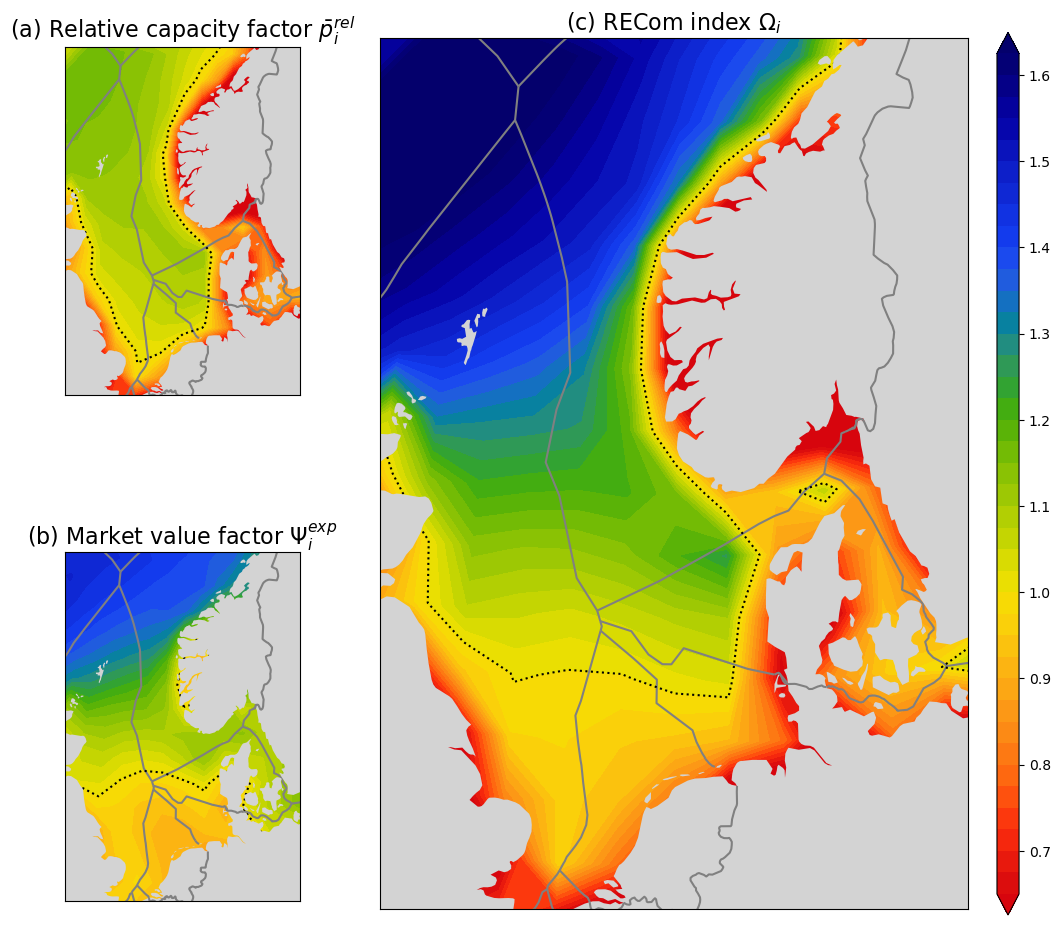

In [49]:
# ALL in subplots
#10x3 -> 5x9

#gs_kw = dict(width_ratios=[1, 1], height_ratios=[0.4, 1])
#fig, axd = plt.subplot_mosaic([['(a)', '(b)'],['(c)', '(c)']],
#    gridspec_kw=gs_kw, figsize=(9, 18),layout="constrained")
gs_kw = dict(width_ratios=[0.8, 2], height_ratios=[1, 1],wspace=0.15)
fig, axd = plt.subplot_mosaic([['(a)', '(c)'],['(b)', '(c)']],
    gridspec_kw=gs_kw, figsize=(10, 10),layout="constrained")
ax1=axd["(a)"]
ax2=axd["(b)"]
ax3=axd["(c)"]
#plt.show()

plot_recov_map(
    Z=cap_factors.unstack().sort_index(axis=1)/mean_cap_factors,
    cmap="cet_rainbow4_r",
    title=f"Relative capacity factor",
    filename=None,#f"output/fig_wind_capacity_factor_relative_{wind_year}.png",
    levels=contour_levels,ticks=contour_ticks,
    contour_lines=[1],ax=ax1,colorbar=False
    )
plot_recov_map(
    Z=psi_value_factor_exp.unstack().sort_index(axis=1),
    cmap="cet_rainbow4_r", #"plasma_r",#"cet_rainbow4_r",
    title=fr"Value factor {wind_year} ($\beta={beta}$)",
    filename=None,#f"output/fig_value_index_exp_{wind_year}.png",
    levels=contour_levels,ticks=contour_ticks,
    contour_lines=[1],ax=ax2,colorbar=False
    )
cf=plot_recov_map(
    Z=omega_recom_index.unstack().sort_index(axis=1),
    cmap="cet_rainbow4_r",
    title=fr"RECom index {wind_year} ($\beta={beta}$)",
    filename=None,#f"output/fig_recov_index_{wind_year}_large.png",
    levels=contour_levels,ticks=contour_ticks,
    contour_lines=[1],dpi=300,scale=2,ax=ax3,colorbar=True,colobar_shrink=0.89
    )

ax1.set_title(r"(a) Relative capacity factor $\bar{p}_i^{rel}$",fontsize=16)
ax2.set_title("(b) Market value factor $\Psi_i^{exp}$",fontsize=16)
ax3.set_title("(c) RECom index $\Omega_i$",fontsize=16)

fig.savefig(f"output/fig_recov_index_2040_MAIN.png",dpi=300,bbox_inches='tight')

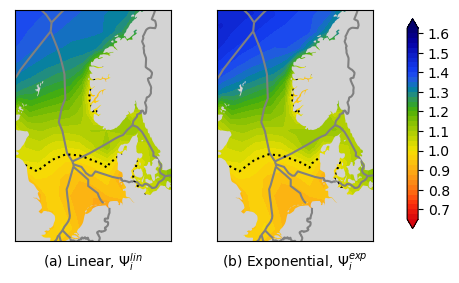

In [79]:
# FIG 11
fig,axs = plt.subplots(1,2,figsize=(5.5,3),sharey=True,sharex=True)
ax1=axs[0]
ax2=axs[1]
plot_recov_map(
    Z=psi_value_factor.unstack().sort_index(axis=1),
    cmap="cet_rainbow4_r", #"plasma_r",#"cet_rainbow4_r",
    title=fr"Value factor {wind_year} ($\beta={beta}$)",
    filename=None,#,f"output/fig_value_index_{wind_year}.png",
    #levels=np.arange(0.6,1.6,0.025),
    #levels=np.arange(0.8,1.8,0.025),
    levels=contour_levels,ticks=contour_ticks,
    contour_lines=[1],ax=ax1,colorbar=False)
# Value factor - Psi^exp
cf=plot_recov_map(
    Z=psi_value_factor_exp.unstack().sort_index(axis=1),
    cmap="cet_rainbow4_r", 
    title=fr"Value factor {wind_year} ($\beta={beta}$)",
    filename=None,
    levels=contour_levels,ticks=contour_ticks,colorbar=False,
    contour_lines=[1],ax=ax2)
ax1.set_xlabel("(a) Linear, $\Psi^{lin}_i$")
ax2.set_xlabel("(b) Exponential, $\Psi^{exp}_i$")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
#fig.colorbar(cf, cax=cbar_ax,contour_ticks = np.arange(0,7,0.61,0.1))
scale=1
fig.colorbar(cf,cax=cbar_ax,ticks=np.arange(0.7,1.61,0.1),aspect=20*scale,extendfrac=0.05/scale,shrink=1)

fig.savefig(f"output/fig_value_index_ALL_2040.png",dpi=300,bbox_inches='tight')

Wind capacity SUM = 39.54299 GW (2025)
Wind capacity SUM = 93.87433470146637 GW (2030)
Wind capacity SUM = 154.42549922553957 GW (2035)
Wind capacity SUM = 205.87433470146635 GW (2040)


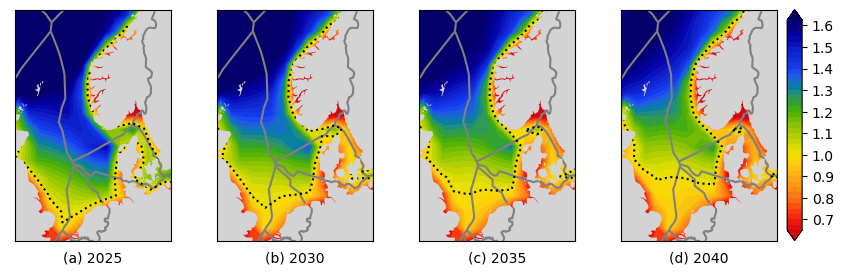

In [88]:
# FIG 12 recom different years

#plt.figure(figsize=(10,3.5))
fig,axs = plt.subplots(nrows=1,ncols=4,figsize=(10,3))
labels = ["a","b","c","d"]
i=0
#ax=None
for wind_year in ["2025", "2030", "2035", "2040"]:
    # Read scenario for expected wind power capacity in given year ("2040")
    windfarms2040 = pd.read_csv("C:/Users/hsven/code/grid_optimisation/windfarm_data/saved_data/windfarms.csv")
    windfarms2040 = windfarms2040[["lat","lon",wind_year]]
    windfarms2040 = windfarms2040[windfarms2040[wind_year]>0]

    # Wind capacity per box:
    wind_cols = df_all_wind.xs("electricity",axis=1,level=2).columns
    wind_cap = pd.Series(index=wind_cols, data=0.0)
    for lat,lon in wind_cols:
        mask_lat = (
            (windfarms2040["lat"]-lat).between(-delta_lat/2,delta_lat/2,inclusive="right")
        )
        mask_lon = (
            (windfarms2040["lon"]-lon).between(-delta_lon/2,delta_lon/2,inclusive="right")
        )
        cap_incl = windfarms2040.loc[mask_lat & mask_lon,wind_year].sum()
        wind_cap[(lat,lon)] = cap_incl/1000
    print(f"Wind capacity SUM = {wind_cap.sum()} GW ({wind_year})")


    # Computations:

    # Wind values at (lat=64,lon=-3.5) are too low, so replace by mean of neighbours instead:
    correct_64_35 = True
    if correct_64_35:
        df_all_wind[(64,-3.5,"wind_speed")] = df_all_wind[[
            (64,-5,"wind_speed"),
            (64,-2,"wind_speed"),
            (63,-3.5,"wind_speed"),
            (65,-3.5,"wind_speed")]].mean(axis=1)
        df_all_wind[(64,-3.5,"electricity")] = df_all_wind[[
            (64,-5,"electricity"),
            (64,-2,"electricity"),
            (63,-3.5,"electricity"),
            (65,-3.5,"electricity")]].mean(axis=1)

    # Mean and standard deviations:
    df_all_windspeed = df_all_wind.xs("wind_speed",axis=1,level=2).copy()
    df_all_wind2 = df_all_wind.xs("electricity",axis=1,level=2).copy()
    wind_sum = df_all_wind.xs("electricity",axis=1,level=2).dot(wind_cap)
    wind_sum_std = wind_sum.std()
    wind_std = df_all_wind2.std()
    wind_mean = df_all_wind2.mean()
    cap_factors = wind_mean
    mean_cap_factors = wind_sum.mean()/wind_cap.sum()  # 0.53 = typical value

    # Covariance:
    df_all_wind2[(0,0)] = wind_sum
    wind_cov_all =df_all_wind2.cov()
    variance_sum = wind_cov_all.loc[(0,0),(0,0)] # = std_sum^2
    wind_cov = wind_cov_all[(0,0)].drop((0,0))#/wind_mean
    wind_cov_factor = wind_cov/(variance_sum/wind_cap.sum())  # relative covariance, cov_rel_i

    # Relative capacity factor, standard deviation and covariance:
    K_rel_i = wind_mean/(wind_sum.mean()/wind_cap.sum())
    sigma_rel_i = wind_std/(wind_sum_std/wind_cap.sum())
    cov_rel_i = wind_cov_factor

    beta = 0.5 #1.0
    phi_complementarity_factor  = 1 + beta*(1-cov_rel_i)
    psi_value_factor =( (1 + beta*(1-cov_rel_i/K_rel_i)))
    psi_value_factor_exp = np.exp(beta*(1-cov_rel_i/K_rel_i))
    omega_recom_index = (K_rel_i*np.exp(beta*(1-cov_rel_i/K_rel_i)))


    ax=axs[i]
    cf=plot_recov_map(
        Z=omega_recom_index.unstack().sort_index(axis=1),
        cmap="cet_rainbow4_r",
        title=fr"RECom index {wind_year} ($\beta={beta}$)",
        filename=None,
        levels=contour_levels,ticks=contour_ticks,
        contour_lines=[1],ax=ax,colorbar=False
    )
    ax.set_xlabel(f"({labels[i]}) {wind_year}")
    i = i+1

ax=axs[-1]
cax = plt.gcf().add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.015,ax.get_position().height])
plt.colorbar(cf,cax=cax,aspect=20,extendfrac=0.05,ticks=contour_ticks)

fig.savefig(f"output/fig_recov_index_ALL.png",dpi=300,bbox_inches='tight')

In [85]:
contour_ticks

array([0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6])

expected capacity


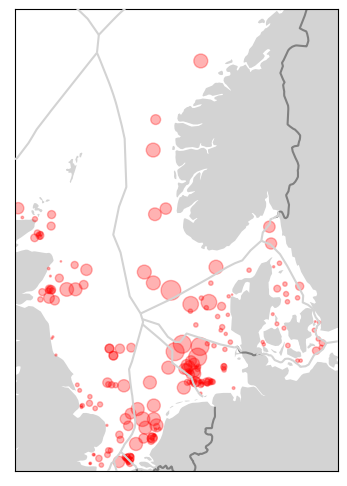

mean wind speed


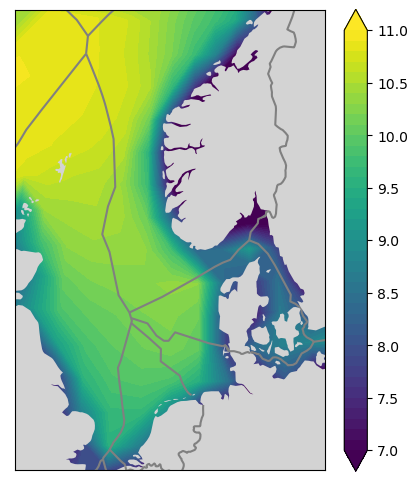

relative capacity factor


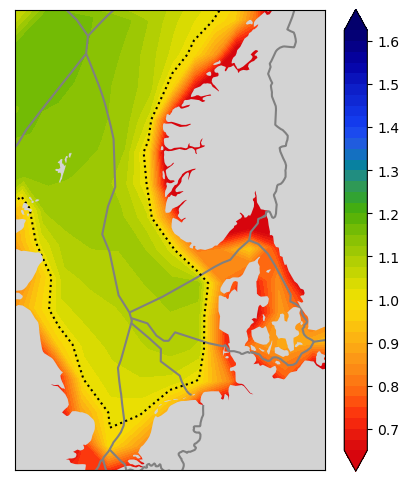

equivalent capacity


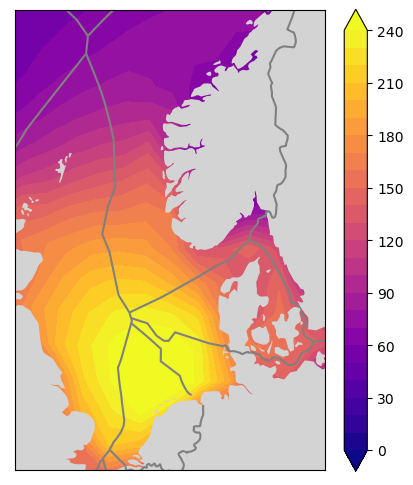

complementarity factor (from covariance only)


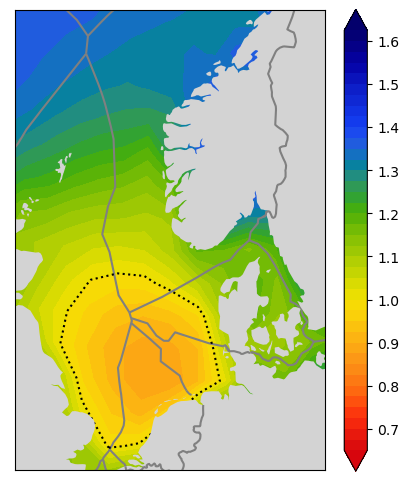

value factor (does not include capacity factor)


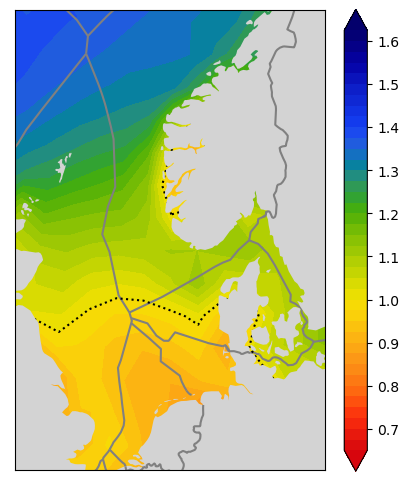

value factor (does not include capacity factor)


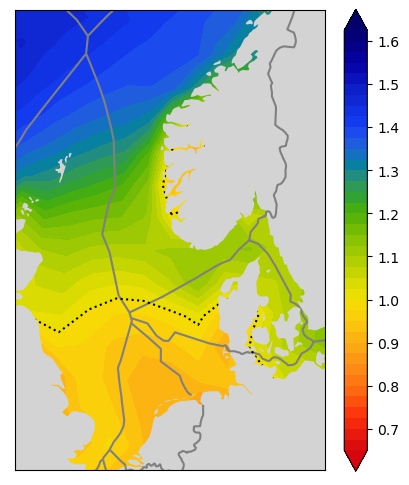

recom index


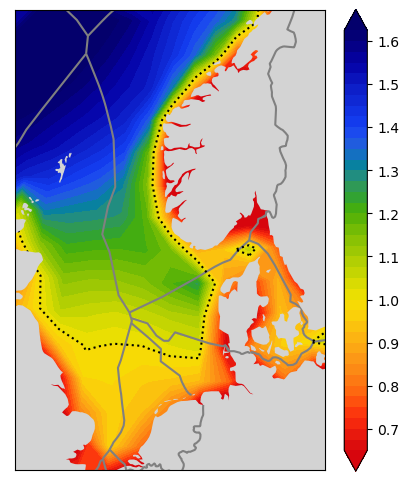

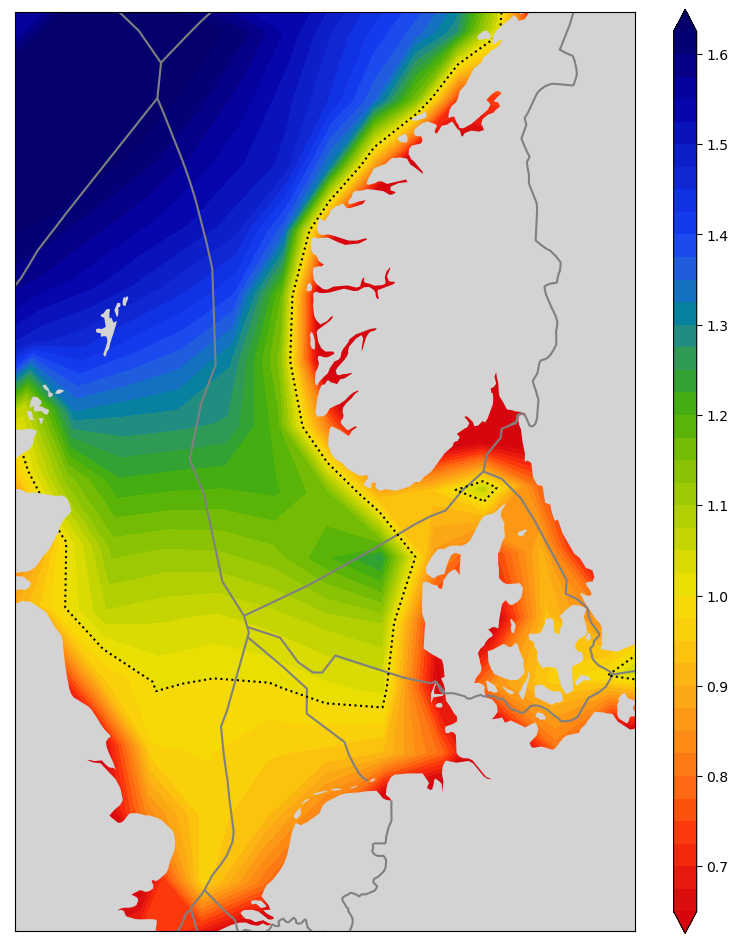

DONE.


In [18]:
# Plot figures for paper

# Expected capacity
print("expected capacity")
proj = lambert_equal_area
plt.figure(figsize=(5,6))
ax=plt.gca()
world.to_crs(proj).plot(ax=ax,color="lightgray")
borders.to_crs(proj).plot(ax=ax,color="gray")
borders_sea.to_crs(proj).plot(ax=ax,color="lightgray",zorder=10)
wf_x,wf_y = p1(windfarms2040["lon"],windfarms2040["lat"])
ax.scatter(x=wf_x,y=wf_y,s=windfarms2040[wind_year]*1/30,alpha=0.3,color="red")
#minmax = p1([-5,22],[49,67])
minmax = p1([-3,16.5],[51,66])
minmax = p1([-2.5,16.5],[51,65]) # cap in the north
ax.set_xlim(minmax[0][0],minmax[0][1])
ax.set_ylim(minmax[1][0],minmax[1][1])
ax.set_xticks([])
ax.set_yticks([])
#plt.title(f"Expected capacity {wind_year} ({wind_cap.sum():.0f} GW)");
plt.savefig(f"output/fig_expected_capacity_scatter_{wind_year}.png",bbox_inches='tight',dpi=150)

# Mean wind speed
plt.show()
print("mean wind speed")
Z = df_all_windspeed.mean().unstack().sort_index(axis=1)
plot_recov_map(
    Z,
    title=f"Mean wind speed at hub height",
    filename=f"output/fig_wind_speed_{wind_year}.png",
    levels=np.arange(7,11.001,0.1),
    cmap="viridis")

# Relative capacity factor - K_rel_i
plt.show()
print("relative capacity factor")
Z = cap_factors.unstack().sort_index(axis=1)/mean_cap_factors
plot_recov_map(
    Z, cmap="cet_rainbow4_r",#"viridis",
    title=f"Relative capacity factor",
    filename=f"output/fig_wind_capacity_factor_relative_{wind_year}.png",
    #levels=np.arange(0.75,1.15001,0.0125),
    levels=contour_levels,ticks=contour_ticks,
    contour_lines=[1],
    )

# Equivalent capacity
plt.show()
print("equivalent capacity")
Z = (wind_cap.sum()*wind_cov_factor).unstack().sort_index(axis=1)
plot_recov_map(
    Z, cmap="plasma",
    title=f"Equivalent capacity {wind_year} ({wind_cap.sum():.0f} GW)",
    filename=f"output/fig_covvariantv_equiv_capacity_{wind_year}.png",
    levels=np.arange(0, 250, 10))

# Complementarity factor - Phi
plt.show()
print("complementarity factor (from covariance only)")
Z = phi_complementarity_factor.unstack().sort_index(axis=1)
plot_recov_map(
    Z,cmap="cet_rainbow4_r", #"plasma_r",
    title=f"Complementarity factor {wind_year}",
    filename=f"output/fig_complementarity_factor_{wind_year}.png",
    #levels=np.arange(0.8, 1.80, 0.025),
    levels=contour_levels,ticks=contour_ticks,
    contour_lines=[1])

# Value factor - Psi
plt.show()
print("value factor (does not include capacity factor)")
Z = psi_value_factor.unstack().sort_index(axis=1)
plot_recov_map(
    Z,cmap="cet_rainbow4_r", #"plasma_r",#"cet_rainbow4_r",
    title=fr"Value factor {wind_year} ($\beta={beta}$)",
    filename=f"output/fig_value_index_{wind_year}.png",
    #levels=np.arange(0.6,1.6,0.025),
    #levels=np.arange(0.8,1.8,0.025),
    levels=contour_levels,ticks=contour_ticks,
    contour_lines=[1])

# Value factor - Psi^exp
plt.show()
print("value factor (does not include capacity factor)")
Z = psi_value_factor_exp.unstack().sort_index(axis=1)
plot_recov_map(
    Z,cmap="cet_rainbow4_r", #"plasma_r",#"cet_rainbow4_r",
    title=fr"Value factor {wind_year} ($\beta={beta}$)",
    filename=f"output/fig_value_index_exp_{wind_year}.png",
    #levels=np.arange(0.6,1.6,0.025),
    #levels=np.arange(0.8,1.8,0.025),
    levels=contour_levels,ticks=contour_ticks,
    contour_lines=[1])


# RECom index - Omega
plt.show()
print("recom index")
Z = omega_recom_index.unstack().sort_index(axis=1)
plot_recov_map(
    Z,cmap="cet_rainbow4_r",
    title=fr"RECom index {wind_year} ($\beta={beta}$)",
    filename=f"output/fig_recov_index_{wind_year}.png",
    #levels=np.arange(0.6,1.6,0.025),
    #levels=np.arange(0.6,2.4,0.05),
    levels=contour_levels,ticks=contour_ticks,
    contour_lines=[1])

# Higher res main plot:
plot_recov_map(
    Z,cmap="cet_rainbow4_r",
    title=fr"RECom index {wind_year} ($\beta={beta}$)",
    filename=f"output/fig_recov_index_{wind_year}_large.png",
    #levels=np.arange(0.6,1.6,0.025),
    levels=contour_levels,ticks=contour_ticks,
    contour_lines=[1],dpi=300,scale=2)
# 0.8..2.2
# cet_CET_R3_r, viridis, jet, rainbow, cet_rainbow4, cet_gouldian
plt.show()
print("DONE.")

Text(2.0, -0.6, 'total wind\npower')

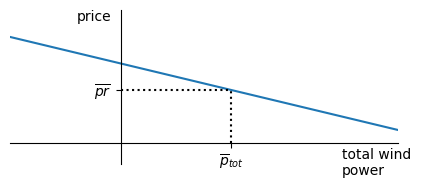

In [37]:
# Illustrate linear wind vs price model
my_beta=0.5
xval = np.arange(-1,6,0.1)
yval_psi_lin = 1+my_beta*(1-xval)
plt.figure(figsize=(5,2))
plt.plot(xval,yval_psi_lin,label="linear")
ax=plt.gca()
ax.spines['left'].set_position(('data', 0))
ax.spines['bottom'].set_position(('data', 0))
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.plot([1,1],[0,1],":k")
plt.plot([0,1],[1,1],":k")
plt.ylim([-0.4,2.5])
plt.xlim([-1,2.5])
plt.xticks([1],[r"$\overline{p}_{tot}$"])
plt.yticks([1],[r"$\overline{pr}$"])
plt
#plt.legend(frameon=False)
plt.annotate(xy=(0,2),xytext=(-0.4,2.3),text="price")
plt.annotate(xy=(0,2),xytext=(2.0,-0.6),text="total wind\npower")

#plt.savefig("output/fig_pricefunction.png",bbox_inches='tight',dpi=150)   

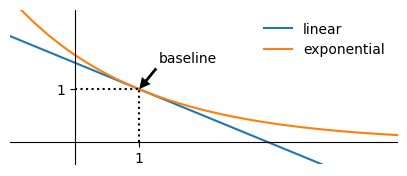

In [86]:
my_beta=0.5
xval = np.arange(-1,6,0.1)
yval_psi_lin = 1+my_beta*(1-xval)
yval_psi_exp = np.exp(my_beta*(1-xval))
plt.figure(figsize=(5,2))
plt.plot(xval,yval_psi_lin,label="linear")
plt.plot(xval,yval_psi_exp,label="exponential")
ax=plt.gca()
ax.spines['left'].set_position(('data', 0))
ax.spines['bottom'].set_position(('data', 0))
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.plot([1,1],[0,1],":k")
plt.plot([0,1],[1,1],":k")
plt.ylim([-0.4,2.5])
plt.xlim([-1,5])
plt.xticks([1])
plt.yticks([1])
plt.legend(frameon=False)
plt.annotate(xy=(1,1),xytext=(1.3,1.5),text="baseline",arrowprops=dict(color='black', width=2,linewidth=0,headwidth=8,headlength=8))
plt.savefig("output/fig_exponential_v2.png",bbox_inches='tight',dpi=150)   

In [ ]:
# Relationship beta and alpha
print(f"mean = {wind_sum.mean():4g} =norm=> {wind_sum.mean()/wind_cap.sum():4g},"
      f"std = {wind_sum_std:4g} =norm>  {wind_sum_std/wind_cap.sum():4g}")
for my_beta in [0, 0.1, 0.206, 0.5, 1, 2]:
    print(f"beta = {my_beta:5g} => alpha = {(1-1/(1+my_beta))*(wind_sum.mean()/wind_sum_std)**2:5.3f}")

mean = 109.699 =norm=> 0.532843,std = 45.3665 =norm>  0.22036
beta =     0 => alpha = 0.000
beta =   0.1 => alpha = 0.532
beta = 0.206 => alpha = 0.999
beta =   0.5 => alpha = 1.949
beta =     1 => alpha = 2.923
beta =     2 => alpha = 3.898


beta=0 => alpha=0.0
beta=0.25 => alpha=1.1693983482571884
beta=0.5 => alpha=1.9489972470953145
beta=1 => alpha=2.9234958706429715


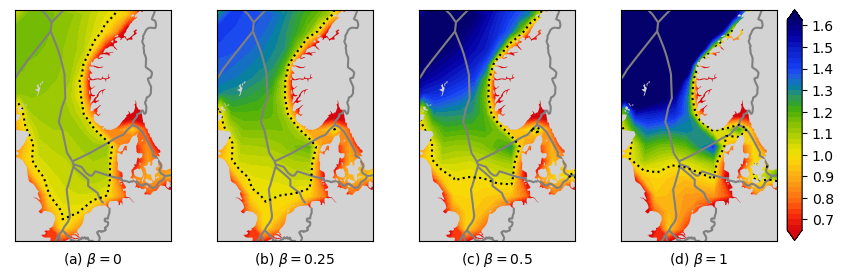

In [94]:
# FIG 14 recom different beta

#plt.figure(figsize=(10,3.5))
fig,axs = plt.subplots(nrows=1,ncols=4,figsize=(10,3))
labels = ["a","b","c","d"]
i=0

i=0
for my_beta in [0, 0.25, 0.5, 1]:   
    my_alpha = (1-1/(1+my_beta))*(wind_sum.mean()/wind_sum_std)**2
    print(f"beta={my_beta} => alpha={my_alpha}")
    omega_recom_index = (K_rel_i*np.exp(my_beta*(1-wind_cov_factor/K_rel_i))).unstack().sort_index(axis=1)
    plot_recov_map(
        omega_recom_index,cmap="cet_rainbow4_r",
        title=fr"RECom index {wind_year} ($\beta={my_beta}$)",
        filename=None,
        levels=contour_levels,ticks=contour_ticks,
        contour_lines=[1],ax=axs[i],colorbar=False)
    axs[i].set_xlabel(fr"({labels[i]}) $\beta={my_beta}$")
    i=i+1

ax=axs[-1]
cax = plt.gcf().add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.015,ax.get_position().height])
plt.colorbar(cf,cax=cax,aspect=20,extendfrac=0.05,ticks=contour_ticks)

fig.savefig(f"output/fig_recov_index_2040_BETA.png",dpi=300,bbox_inches='tight')


0.5


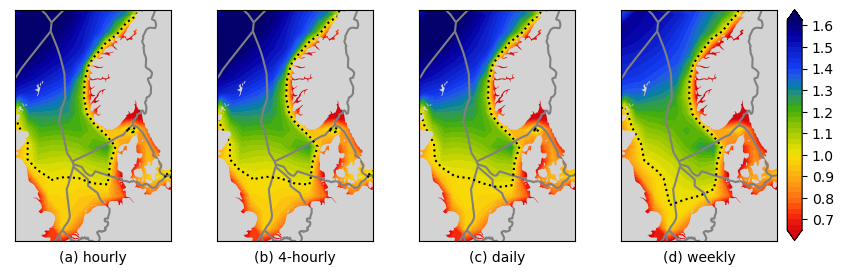

In [96]:
# FIG 13: recom dependence on sampling

print(beta)
fig,axs = plt.subplots(nrows=1,ncols=4,figsize=(10,3))
labels = ["(a) hourly","(b) 4-hourly","(c) daily","(d) weekly"]
i=0
for hours in [1, 4, 24, 24*7]:
    df_all_wind2.index = pd.DatetimeIndex(df_all_wind2.index)
    df_24h = df_all_wind2.resample(f"{hours}h").mean()

    # Covariance:
    cov_24h_all =df_24h.cov()
    var_24h_sum = cov_24h_all.loc[(0,0),(0,0)] # = std_sum^2
    cov_24h = cov_24h_all[(0,0)].drop((0,0))#/wind_mean
    wind_cov_factor_24h = cov_24h/(var_24h_sum/wind_cap.sum())
    K_rel_i_24h = cap_factors/mean_cap_factors

    #beta=1
    recom_index_24h = (K_rel_i_24h*np.exp(beta*(1-wind_cov_factor_24h/K_rel_i_24h))).unstack().sort_index(axis=1)

    plot_recov_map(
        recom_index_24h,cmap="cet_rainbow4_r",
        levels=contour_levels,ticks=contour_ticks,
        contour_lines=[1],colorbar=False,ax=axs[i])
    axs[i].set_xlabel(labels[i])
    i=i+1
ax=axs[-1]
cax = plt.gcf().add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.015,ax.get_position().height])
plt.colorbar(cf,cax=cax,aspect=20,extendfrac=0.05,ticks=contour_ticks)

fig.savefig(f"output/fig_recov_index_2040_SAMPLING.png",dpi=300,bbox_inches='tight')

In [ ]:
gdf_wind_mean = geopandas.GeoDataFrame(wind_mean,geometry=datapoints.geometry)
mask_off = [~world.contains(x.geometry).any() for i,x in gdf_wind_mean.iterrows()]
gdf_wind_std = geopandas.GeoDataFrame(wind_std,geometry=datapoints.geometry)
mask_off1 = [~world.contains(x.geometry).any() for i,x in gdf_wind_std.iterrows()]

print("TYPICAL VALUES:"
    f"\np_ext =       {wind_sum.mean()/wind_cap.sum():7.3}"
    f"\np_i =         {wind_mean.mean():7.3} (mean) / {wind_mean.median():7.3} (median)"
    f"\np_i_offshore= {gdf_wind_mean.loc[mask_off,0].mean():7.3} (mean) / {gdf_wind_mean.loc[mask_off,0].median():7.3} (median)"
    f"\nσ_ext =       {wind_sum_std/wind_sum.mean():7.3}"
    f"\nσ_i =         {wind_std.mean():7.3} (mean) / {wind_std.median():7.3} (median)"
    f"\nσ_i_offshore= {gdf_wind_std.loc[mask_off,0].mean():7.3} (mean) / {gdf_wind_std.loc[mask_off,0].median():7.3} (median)")

TYPICAL VALUES:
p_ext =         0.533
p_i =           0.427 (mean) /   0.459 (median)
p_i_offshore=   0.546 (mean) /   0.567 (median)
σ_ext =         0.414
σ_i =           0.266 (mean) /   0.288 (median)
σ_i_offshore=   0.308 (mean) /   0.312 (median)


In [ ]:
# 1/(1+beta) = 1- alpha sigma_tot^2/p_tot_mean^2
print(f"p_total_std = {wind_sum.std()/wind_cap.sum()}")
print(f"p_total_mean = {wind_sum.mean()/wind_cap.sum()}")
beta_factor=0.21
alpha_factor = (1-1/(1+beta_factor))*(wind_sum.mean()/wind_cap.sum())**2/(wind_sum.std()/wind_cap.sum())**2
print(f"beta = {beta_factor} => alpha = {alpha_factor}")

p_total_std = 0.22035995255111582
p_total_mean = 0.5328425651820876
beta = 0.21 => alpha = 1.0147671617107834
